### 3) 신경망에서의 단어 처리

In [1]:
# 완전연결계층에 의한 변환 구현
import numpy as np

c = np.array([[1,0,0,0,0,0,0]]) # 입력
W = np.random.randn(7, 3) # 가중치
h = np.matmul(c,W) # 중간 노드 : 완전연결계층의 계산은 행렬 곱(matmul)으로 수행
print(h)

[[-0.38532333 -0.24705408  2.53592273]]


- 단어 ID가 0인 단어를 원핫 표현으로 표현한 후 완전연결계층에 통과시켜 변환

- h, 즉 c와 W의 행렬 곱의 결과 = 가중치의 행벡터 하나를 뽑아낸 것 : 비효율적!

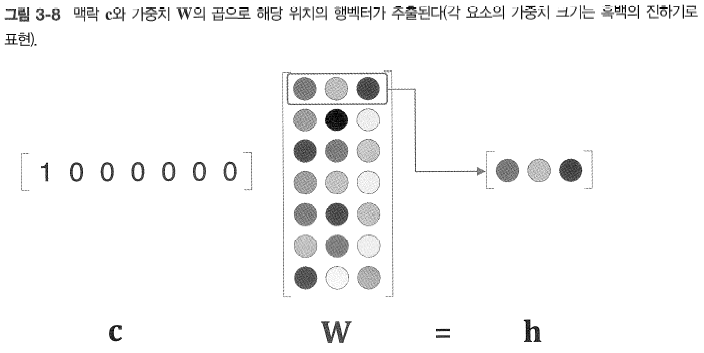

In [4]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

In [5]:
# MatMul 계층으로 똑같은 작업 수행
c = np.array([[1,0,0,0,0,0,0]]) # 입력
W = np.random.randn(7, 3) # 가중치
layer = MatMul(W)
h = layer.forward(c) # 순전파 수행
print(h)

[[-1.09725328 -1.39727568 -0.84418905]]


## 2. 단순한 word2vec

CBOW(Continuous bag-of-words) 모델 : word2vec에서 제안하는 신경망

### 1) CBOW 모델의 추론 처리
- 활성화 함수를 이용하지 않는 간단한 구성의 신경망  
- 입력층 여러 개 & 입력층들이 가중치를 공유함  
- 맥락으로부터 타깃(중앙 단어)을 추측하는 용도의 신경망
- 입력 : 맥락(주변 단어들의 목록) → 맥락을 원핫 표현으로 변환  
<br>  
### "뉴런 관점"의 CBOW 모델
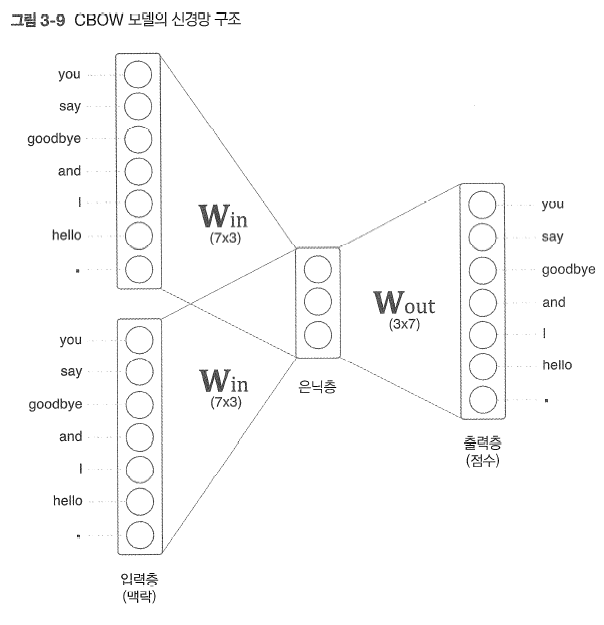



- 입력층 2개 → 은닉층 → 출력층 7개 
- 입력층 → 은닉층 변환 : 완전연결계층 가중치 Win = 단어의 분산 표현의 정체  
- Win의 각 행에는 각각 해당 단어의 분산 표현이 담겨 있음  
- 학습이 진행될수록 맥락에서 출현하는 단어를 잘 추측하는 방향으로 분산 표현들이 갱신  

<br>  

#### a. 입력층
- 입력층이 2개인 이유 : 맥락으로 고려할 단어를 2개로 정했기 때문.  
  → 맥락에 포함시킬 단어가 N개라면 입력층 N개  
<br>  

#### b. 은닉층
- 은닉층의 뉴런 : 입력층의 완전연결계층에 의해 변환된 값  
     → 입력층이 여러 개라면 전체를 '평균'계산  
<br>  

#### c. 출력층
- 출력층의 각 뉴런들이 각각 단어에 대응
- 출력층 뉴런 : 각 단어의 '점수(확률로 해석되기 전 값)' 의미  
  → 값이 높을수록 대응 단어의 출현 확률(소프트맥스 함수 적용) ↑  

Point. 은닉층의 뉴런 수 < 입력층의 뉴런 수  
- 은닉층 : 단어 예측에 필요한 정보를 "간결하게" 담아 밀집벡터 표현을 얻도록!  
- 은닉층의 정보 : 인간은 이해할 수 없는 코드 = "인코딩"  
- 은닉층의 정보(인코딩)로부터 인간이 이해할 수 있는 표현으로 복원하는 작업 = "디코딩"  

### "계층 관점"에서의 CBOW 모델
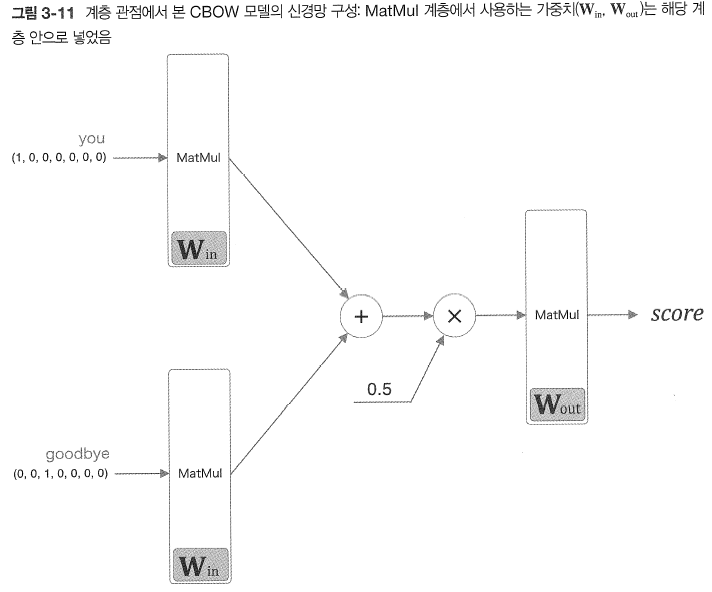

- 2개의 MatMul 계층이 합해짐 → 은닉층 뉴런 = 값 X 0.5 ("평균") → 은닉층 뉴런에 MatMul 계층 적용 → 점수 출력  

In [1]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층(MatMul 계층) 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in) # 입력층 2개 : 가중치 W_in을 공유!!
out_layer = MatMul(W_out) #출력층 1개

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)  # average
s = out_layer.forward(h)  # score

print(s)

[[ 0.25503583 -0.14074335  0.12682027 -0.32814229 -0.02654554 -0.04934724
  -0.22701794]]


### 2) CBOW 모델의 학습
"확률" : CBOW 모델의 출력층에서 출력된 점수 → softmax 함수 적용
- 맥락(전후 주변 단어)이 주어졌을 때 그 중앙에 어떤 단어가 출현할지 나타냄  
- 가중치가 적절한 신경망이라면 정답에 해당하는 뉴런의 확률값이 가장 클 것임  
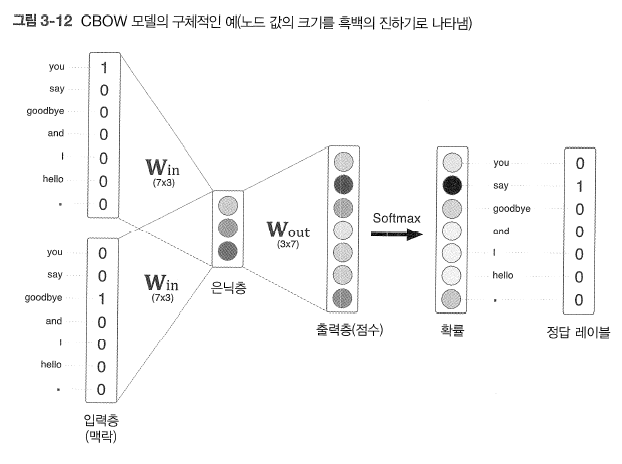


학습 : 올바른 예측을 위해 가중치를 조정  
- 결과 : 가중치에 단어의 출현 패턴을 파악한 벡터가 학습  
- 단어 출현 패턴을 학습 시 사용한 말뭉치로부터 배우므로 말뭉치가 다르면 학습 후 단어의 분산 표현도 달라짐  

#### CBOW 모델 학습 신경망 구성
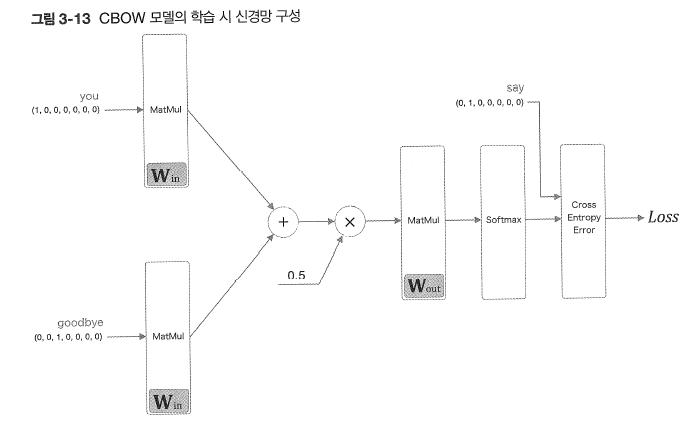 
- **softmax 함수**로 확률로 변환 → 확률&정답레이블로 **교차 엔트로피 오차** 계산 → 값을 **손실**로 사용해 학습 진행  
→ CBOW 모델의 손실을 구하는 계신의 흐름, 곧 이 신경망의 "순방향 전파"  
→ Softmax 계층 + Cross Entropy Error 계층을 합쳐 Softmax with Loss 계층으로 구현  

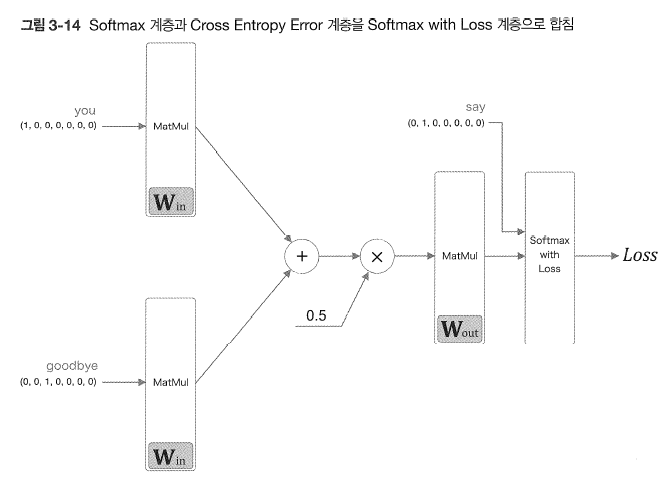

### 3) word2vec의 가중치와 분산 표현
- 입력 측 가중치 W(in) : 각 행이 각 단어의 분산 표현에 해당  
- 출력 측 가중치 W(out) : 단어의 의미가 인코딩된 벡터 저장, 단 각 단어의 분산 표현이 열 방향으로 저장  
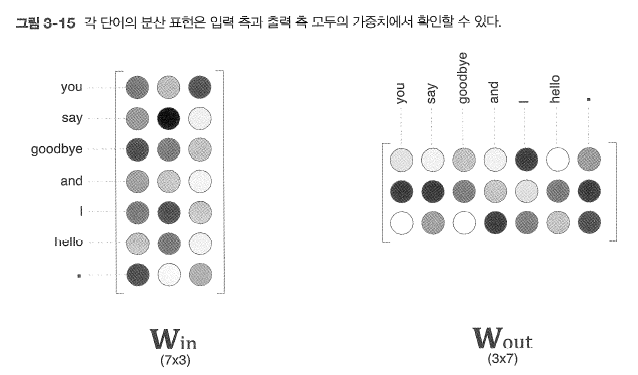

**단어의 분산 표현으로 어느 쪽 가중치를 선택할까?**  
- 대부분의 연구 : 출력 측 가중치 버리고 입력 측 가중치만 최종 단어 분산 표현으로 이용

## 3. 학습 데이터 준비
### 1) 맥락과 타깃

- 신경망의 입력 : **맥락**(contexts) - 1개 이상  
- 정답 레이블 : **타깃** - 맥락에 둘러싸인 중앙 단어,예측해야 하는 단어, 오직 1개  
- 목표 : 신경망에 **맥락**을 입력했을 때 **타깃**이 출현할 확률을 높임

In [2]:
#말뭉치 텍스트를 단어 ID로 변환
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus) # 단어 ID의 배열
print(id_to_word) 

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [3]:
def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성 함수
    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: (맥락, 타겟)의 np.array
    '''
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        # wiondow_size만큼 타겟 단어 좌우 context 가져오기
        for t in range(-window_size, window_size+1):
            if t != 0:
                cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [5]:
contexts, target = create_contexts_target(corpus,window_size = 1)
print(contexts) #2차원 배열
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


### 2) 원핫 표현으로 변환
- 단어 ID로 표현된 맥락과 타깃을 원핫 표현으로 변환 : contexts는 3차원 넘파이 배열  
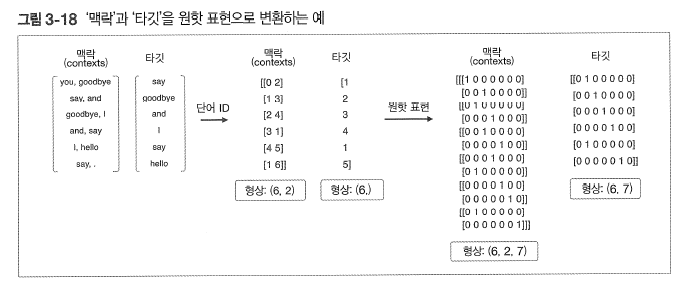

In [6]:
# 원핫 표현 변환 함수로 convert_one_hot 함수 사용
import sys
sys.path.append('..')
from common.util import preprocess,create_contexts_target,convert_one_hot

text = 'You say goodbye and I say hello.'
corpus,word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus,window_size = 1)

vocab_size = len(word_to_id)
target = convert_one_hot(target,vocab_size)
contexts = convert_one_hot(contexts,vocab_size) #인수로 단어 ID 목록과 어휘 수 받음

## 4. CBOW 모델 구현
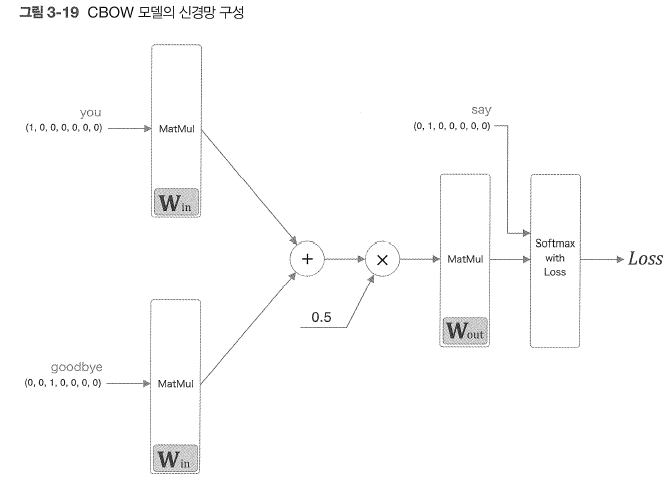

In [7]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size): # vocab_size : 어휘 수, hidden_size : 은닉층 뉴런 수
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화(32비트 부동소수점 수로 초기화)
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in) # 입력 측 MatMul 계층 2개(맥락의 단어 수만큼 생성) : 모두 같은 가중치 이용
        self.out_layer = MatMul(W_out) # 출력 측 MatMul 계층 1개
        self.loss_layer = SoftmaxWithLoss() # Softmax with Loss 계층 1개
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out.T

In [8]:
# 맥락, 타깃을 인수로 받아 손실 반환
def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

**contexts** : 3차원 넘파이 배열
> (미니배치의 수, 맥락의 윈도우 크기, 원핫 벡터)  

**target** : 2차원 넘파이 배열

In [9]:
# 역전파 구현
def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

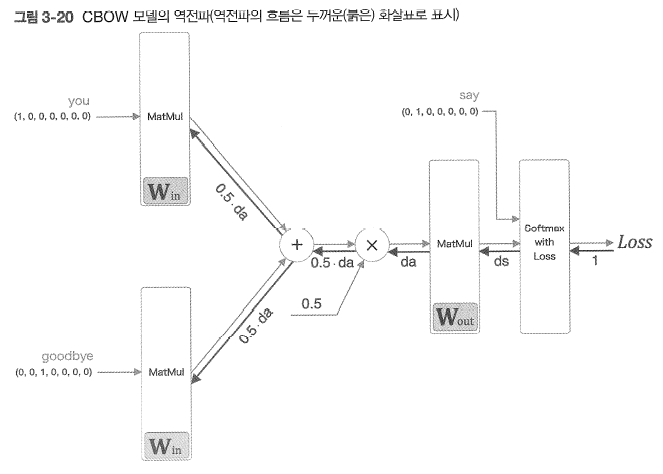

**역전파**  
: 1 → Softmax with Loss 계층에 입력(출력 = ds) → 출력 측 MatMul 계층에 입력  
  → 'X'(순전파 입력을 서로 바꿔 기울기에 곱함)와 '+'(기울기 그대로 통과) 연산 역전파

#### 1) 학습 코드 구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 251 |  반복 1 / 2 | 시간 0[s] | 손실 1.11
| 에폭 252 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 253 |  반복 1 / 2 | 시간 0[s] | 손실 0.91
| 에폭 254 |  반복 1 / 2 | 시간 0[s] | 손실 1.16
| 에폭 255 |  반복 1 / 2 | 시간 0[s] | 손실 0.97
| 에폭 256 |  반복 1 / 2 | 시간 0[s] | 손실 1.07
| 에폭 257 |  반복 1 / 2 | 시간 0[s] | 손실 1.04
| 에폭 258 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 259 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 260 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 261 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 262 |  반복 1 / 2 | 시간 0[s] | 손실 1.12
| 에폭 263 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 264 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 265 |  반복 1 / 2 | 시간 0[s] | 손실 0.98
| 에폭 266 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 267 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 268 |  반복 1 / 2 | 시간 0[s] | 손실 0.97
| 에폭 269 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 270 |  반복 1 / 2 | 시간 0[s] | 손실 1.00
| 에폭 271 |  반복 1 / 2 | 시간 0[s] | 손실 0.96
| 에폭 272 |  반복 1 / 2 | 시간 0[s] | 손실 1.03
| 에폭 273 |  반복 1 / 2 | 시간 0[s] | 손실 0.87
| 에폭 274 |  반복 1 / 2 | 시간 0[s] | 손실 1.11
| 에폭 275 |  반복 1

| 에폭 454 |  반복 1 / 2 | 시간 1[s] | 손실 0.56
| 에폭 455 |  반복 1 / 2 | 시간 1[s] | 손실 0.70
| 에폭 456 |  반복 1 / 2 | 시간 1[s] | 손실 0.63
| 에폭 457 |  반복 1 / 2 | 시간 1[s] | 손실 0.63
| 에폭 458 |  반복 1 / 2 | 시간 1[s] | 손실 0.63
| 에폭 459 |  반복 1 / 2 | 시간 1[s] | 손실 0.62
| 에폭 460 |  반복 1 / 2 | 시간 1[s] | 손실 0.60
| 에폭 461 |  반복 1 / 2 | 시간 1[s] | 손실 0.55
| 에폭 462 |  반복 1 / 2 | 시간 1[s] | 손실 0.72
| 에폭 463 |  반복 1 / 2 | 시간 1[s] | 손실 0.52
| 에폭 464 |  반복 1 / 2 | 시간 1[s] | 손실 0.65
| 에폭 465 |  반복 1 / 2 | 시간 1[s] | 손실 0.60
| 에폭 466 |  반복 1 / 2 | 시간 1[s] | 손실 0.69
| 에폭 467 |  반복 1 / 2 | 시간 1[s] | 손실 0.47
| 에폭 468 |  반복 1 / 2 | 시간 1[s] | 손실 0.79
| 에폭 469 |  반복 1 / 2 | 시간 1[s] | 손실 0.61
| 에폭 470 |  반복 1 / 2 | 시간 1[s] | 손실 0.52
| 에폭 471 |  반복 1 / 2 | 시간 1[s] | 손실 0.61
| 에폭 472 |  반복 1 / 2 | 시간 1[s] | 손실 0.71
| 에폭 473 |  반복 1 / 2 | 시간 1[s] | 손실 0.61
| 에폭 474 |  반복 1 / 2 | 시간 1[s] | 손실 0.51
| 에폭 475 |  반복 1 / 2 | 시간 1[s] | 손실 0.61
| 에폭 476 |  반복 1 / 2 | 시간 1[s] | 손실 0.63
| 에폭 477 |  반복 1 / 2 | 시간 1[s] | 손실 0.68
| 에폭 478 |  반복 1

| 에폭 717 |  반복 1 / 2 | 시간 2[s] | 손실 0.44
| 에폭 718 |  반복 1 / 2 | 시간 2[s] | 손실 0.41
| 에폭 719 |  반복 1 / 2 | 시간 2[s] | 손실 0.50
| 에폭 720 |  반복 1 / 2 | 시간 2[s] | 손실 0.38
| 에폭 721 |  반복 1 / 2 | 시간 2[s] | 손실 0.37
| 에폭 722 |  반복 1 / 2 | 시간 2[s] | 손실 0.45
| 에폭 723 |  반복 1 / 2 | 시간 2[s] | 손실 0.41
| 에폭 724 |  반복 1 / 2 | 시간 2[s] | 손실 0.41
| 에폭 725 |  반복 1 / 2 | 시간 2[s] | 손실 0.45
| 에폭 726 |  반복 1 / 2 | 시간 2[s] | 손실 0.34
| 에폭 727 |  반복 1 / 2 | 시간 2[s] | 손실 0.31
| 에폭 728 |  반복 1 / 2 | 시간 2[s] | 손실 0.54
| 에폭 729 |  반복 1 / 2 | 시간 2[s] | 손실 0.26
| 에폭 730 |  반복 1 / 2 | 시간 2[s] | 손실 0.51
| 에폭 731 |  반복 1 / 2 | 시간 2[s] | 손실 0.40
| 에폭 732 |  반복 1 / 2 | 시간 2[s] | 손실 0.36
| 에폭 733 |  반복 1 / 2 | 시간 2[s] | 손실 0.40
| 에폭 734 |  반복 1 / 2 | 시간 2[s] | 손실 0.49
| 에폭 735 |  반복 1 / 2 | 시간 2[s] | 손실 0.29
| 에폭 736 |  반복 1 / 2 | 시간 2[s] | 손실 0.35
| 에폭 737 |  반복 1 / 2 | 시간 2[s] | 손실 0.47
| 에폭 738 |  반복 1 / 2 | 시간 2[s] | 손실 0.33
| 에폭 739 |  반복 1 / 2 | 시간 2[s] | 손실 0.45
| 에폭 740 |  반복 1 / 2 | 시간 2[s] | 손실 0.45
| 에폭 741 |  반복 1

| 에폭 944 |  반복 1 / 2 | 시간 2[s] | 손실 0.30
| 에폭 945 |  반복 1 / 2 | 시간 2[s] | 손실 0.32
| 에폭 946 |  반복 1 / 2 | 시간 2[s] | 손실 0.24
| 에폭 947 |  반복 1 / 2 | 시간 2[s] | 손실 0.32
| 에폭 948 |  반복 1 / 2 | 시간 2[s] | 손실 0.43
| 에폭 949 |  반복 1 / 2 | 시간 2[s] | 손실 0.30
| 에폭 950 |  반복 1 / 2 | 시간 2[s] | 손실 0.31
| 에폭 951 |  반복 1 / 2 | 시간 2[s] | 손실 0.34
| 에폭 952 |  반복 1 / 2 | 시간 2[s] | 손실 0.33
| 에폭 953 |  반복 1 / 2 | 시간 2[s] | 손실 0.31
| 에폭 954 |  반복 1 / 2 | 시간 2[s] | 손실 0.33
| 에폭 955 |  반복 1 / 2 | 시간 2[s] | 손실 0.32
| 에폭 956 |  반복 1 / 2 | 시간 2[s] | 손실 0.40
| 에폭 957 |  반복 1 / 2 | 시간 2[s] | 손실 0.31
| 에폭 958 |  반복 1 / 2 | 시간 2[s] | 손실 0.24
| 에폭 959 |  반복 1 / 2 | 시간 2[s] | 손실 0.29
| 에폭 960 |  반복 1 / 2 | 시간 2[s] | 손실 0.34
| 에폭 961 |  반복 1 / 2 | 시간 2[s] | 손실 0.32
| 에폭 962 |  반복 1 / 2 | 시간 2[s] | 손실 0.30
| 에폭 963 |  반복 1 / 2 | 시간 2[s] | 손실 0.32
| 에폭 964 |  반복 1 / 2 | 시간 2[s] | 손실 0.30
| 에폭 965 |  반복 1 / 2 | 시간 2[s] | 손실 0.44
| 에폭 966 |  반복 1 / 2 | 시간 2[s] | 손실 0.20
| 에폭 967 |  반복 1 / 2 | 시간 2[s] | 손실 0.33
| 에폭 968 |  반복 1

C:\Users\Jeon Jiwoo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Jeon Jiwoo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Jeon Jiwoo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Jeon Jiwoo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Jeon Jiwoo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Jeon Jiwoo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning

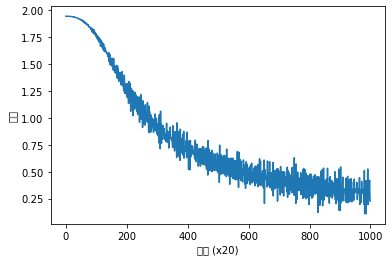

In [12]:
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.trainer import Trainer
from common.optimizer import Adam
from ch03.simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam() # 매개변수 갱신 방법으로 Adam 선택
trainer = Trainer(model, optimizer) # 학습 데이터에서 미니배치 선택, 신경망에 입력해 기울기 계산, 기울기를 Optimizer에 넘겨 매개변수 갱신

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

위 그래프는 학습 경과를 그래프로 표시한 것.(가로축은 학습 횟수, 세로축은 손실)
- 학습을 거듭할수록 손실이 줄어든다.

In [13]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-1.1870154  -1.6597174   0.94708985 -0.88869816 -0.67902887]
say [ 1.3374467  -0.27408457 -0.25301623  1.2789384   0.5876543 ]
goodbye [-0.5058417  0.4519642  1.0967073 -1.0645503 -1.3471459]
and [ 1.0876184 -1.2887931  1.4999883  1.0399802  1.2937739]
i [-0.5146301   0.43181598  1.1294054  -1.0943042  -1.3446372 ]
hello [-1.1621143  -1.6409376   0.93789333 -0.9005338  -0.6728495 ]
. [ 1.1772103  1.2540562 -1.2510754  1.14124   -1.5715891]


**학습이 끝난 후 가중치 매개변수** : 단어를 밀집벡터로 표현, 이 밀집벡터가 "단어의 분산 표현"

## 5. word2vec 보충
### 1) CBOW 모델과 확률

**동시 확률** : A와 B가 동시에 일어날 확률 $$P(A,B)$$

**사후 확률** : 사건이 일어난 후의 확률, B가 주어졌을 때 A가 일어날 확률 $$P(A|B)$$

**CBOW 모델을 확률 표기법으로 기술해보자!**  
- 맥락을 주면 타깃 단어가 출현할 확률을 출력
<br>

- 말뭉치 : $$w_1,w_2,...,w_r$$
<br>

- 윈도우 크기가 1일 때, 맥락으로 $$w_{t-1}, w_{t+1}$$가 주어짐!  
- 이 때, 타깃이 $$w_t$$가 될 확률 = $$P(w_t|w_{t-1},w_{t+1})$$
<br>
- w_{t-1}과 w_{t+1}이 주어졌을 때 w_t가 일어날 확률

**CBOW 모델의 손실 함수(음의 로그 가능도)**
$$L = -logP(w_t | w_{t-1},w_{t+1})$$
- 샘플 데이터 하나에 대한 손실 함수

**CBOW 모델의 손실 함수(말뭉치 전체로 확장)**
$$L =  -\frac{1}{T}\sum_{t = 1}^{T}{
logP(w_t | w_{t-1},w_{t+1})}$$  
- CBOW 모델의 학습 : 손실함수의 값을 최대한 작게 만드는 역할!  
- 손실함수의 값이 가장 작을 때의 가중치 매개변수 : 얻고자 한 단어의 분산 표현

### 2) skip-gram 모델
word2vec이 제안하는 또 다른 모델  
- CBOW의 맥락과 타깃을 역전시킨 모델  
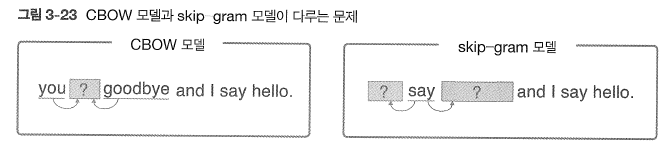

CBOW 모델 : 맥락 여러 개, 여러 맥락으로부터 타깃 추측  
skip-gram 모델 : 타깃으로부터 주변 맥락 추측  

#### skip-gram 모델의 신경망
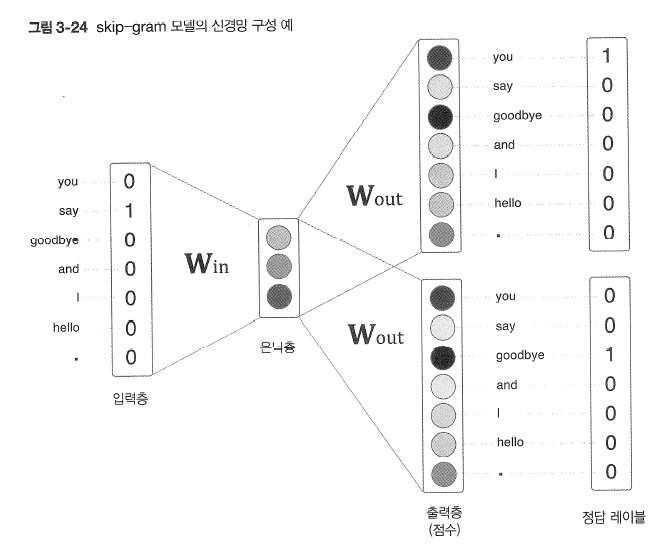

- 입력층 : 한 개  
- 출력층 : 맥락의 수만큼 존재  
> 각 출력층에서 개별적으로 손실 계산 → 최종 손실 = 개별 손실값을 모두 더한 값

**skip-gram 모델을 확률 표기법으로 기술해보자!**  
타깃 w_t로부터 맥락인 w_{t-1}과 w_{t+1}을 추측!
$$P(w_{t-1},w_{t+1}|w_t)$$  
- 타깃이 주어졌을 때 맥락 w_{t-1}과 w_{t+1}이 동시에 일어날 확률

- **조건부 독립** 가정 : 맥락의 단어들 사이 관련성이 없다고 가정  
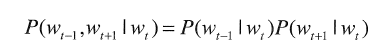

**skip-gram 모델의 손실 함수(교차 엔트로피 오차 적용)**
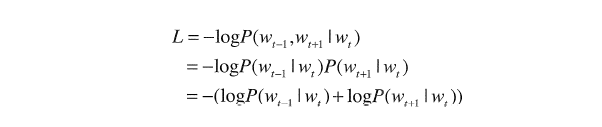  
- 샘플 데이터 한 개에 대한 skip-gram 손실 함수

**skip-gram 모델의 손실 함수(말뭉치 전체로 확장)**
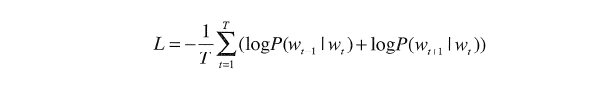

**CBOW 모델 손실함수 vs. skip-gram 모델 손실함수**  
- CBOW 모델 : 타깃 하나의 손실을 계산  
- skip-gram 모델 : 맥락의 수만큼 추측하므로 손실 함수는 각 맥락에서 구한 손실의 총합

**단어 분산 표현의 정밀도 측면에서 skip-gram 모델의 결과가 더 좋은 경우가 많다!**  
**특히 말뭉치가 커질수록 저빈도 단어/유추 문제의 성능 측면에서 skip-gram 모델이 뛰어나다!**  
<br>

**CBOW 모델이 학습 속도 면에서는 훨씬 빠르다. skip-gram 모델은 손실을 맥락의 수만큼 구해야 하므로 계산 비용이 커지기 때문이다!**

### 3) 통계 기반 vs. 추론 기반
**통계 기반 기법**  
a. 말뭉치의 전체 통계로부터 1회 학습해 단어의 분산 표현을 얻었다.  
b. 새 단어를 추가해 단어의 분산 표현을 갱신하는 상황 : 계산을 처음부터 다시! 동시발생 행렬 생성, SVD 수행...  
c. 분산 표현 : 주로 단어의 유사성이 인코딩
<br>

**추론 기반 기법(word2vec)**  
a. 말뭉치를 일부분씩 여러 번 보면서 학습(미니배치 학습)
b. 매개변수 다시 학습 가능 : 기존 학습한 가중치를 초깃값으로 사용해 다시 학습 가능  
c. 분산 표현 : 단어의 유사성 + 한층 복잡한 단어 사이 패턴까지 파악돼 인코딩  
<br>

⇒ 실제 단어의 유사성을 정량 평가하면 통계 기반과 추론 기반 기법의 우열 가릴 수 없다고 한다!(**하이퍼파라미터에 크게 의존하다고...**)  
<br>

⇒ 추론 기반 기법과 통계 기반 기법은 (특정 조건 하에) 서로 관련/연결되어 있다!  
<br>

⇒ word2vec 이후 추론 기반 기법과 통계 기반 기법을 융합한 **GloVe** 기법 등장!  
> 말뭉치 전체의 통계 정보를 손실 함수에 도입해 미니배치 학습 수행